# Práctica de árboles y ajuste de hiperparámetros

La siguiente práctica consiste en crear un modelo usando árbol de decisión de los datos indios de diabetes encontrados en Kaggle y utilizados en la práctica anterior.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
from pyDOE2 import lhs
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 1. Carga y preprocesamiento de datos

Haga la carga y las transformaciones necesarias en los datos.  No olvide dividir los datos en entrenamiento y pruebas.  Use una división 85%-15%.

In [2]:
df_diabetes = pd.read_csv("diabetes.csv")

# Check for missing values
print(df_diabetes.isnull().sum())

# Drop rows with missing values (if any)
df_diabetes.dropna(inplace=True)

# Check for duplicate rows and remove them
df_diabetes.drop_duplicates(inplace=True)

# Reset the index after cleaning
df_diabetes.reset_index(drop=True, inplace=True)

# Display basic statistics to verify the dataset
print(df_diabetes.describe())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedig

## 2.a - Regresión lineal

Copie acá una versión de la regresión lineal para los datos indios de diabetes.  Puede ser la versión de LASSO, Ridge o Elastic Net, pero eso sí escoja el mejor modelo que obtuvo.

In [3]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

feature_cols = [ 'Glucose', 'BMI', 'Age','DiabetesPedigreeFunction','SkinThickness','Pregnancies','BloodPressure']
X = df_diabetes[feature_cols] # Características (variables independientes)
y = df_diabetes.Insulin # Variable objetivo

n = X.shape[0] # used to calculate f statistics

alphas = [0.01, 0.1, 1, 10, 100]

# LASSO regression with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X, y)

# Predictions and R2 score
y_pred_lasso = lasso_cv.predict(X)
lasso_r2 = r2_score(y, y_pred_lasso)

# Calculate F-statistic
p_lasso = np.sum(lasso_cv.coef_ != 0)  # number of non-zero predictors
if p_lasso > 0:
    lasso_f_statistic = (lasso_r2 / p_lasso) / ((1 - lasso_r2) / (n - p_lasso - 1))
else:
    lasso_f_statistic = np.nan  # avoid division by zero

print(f"F-statistic: {lasso_f_statistic:.3f}")
print(f"Best alpha: {lasso_cv.alpha_}")
print(f"R2 score (train): {lasso_r2:.3f}")
print("Coefficients:", dict(zip(X.columns, lasso_cv.coef_)))

F-statistic: 52.791
Best alpha: 10.0
R2 score (train): 0.294
Coefficients: {'Glucose': 1.1893686585138454, 'BMI': -0.2773071513419544, 'Age': -0.551721396167091, 'DiabetesPedigreeFunction': 0.0, 'SkinThickness': 3.005348539608807, 'Pregnancies': -0.7700873561806191, 'BloodPressure': -0.12611637821623145}


## 2.b - Versión de regresión lineal visto en clase

In [4]:
from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import StandardScaler

pima = pd.read_csv("diabetes.csv")

# Define las características y la variable objetivo
feature_cols = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'SkinThickness', 'Pregnancies', 'BloodPressure', 'Insulin']
X = pima[feature_cols]  # Características (variables independientes)
y = pima['Outcome']     # Variable objetivo (ahora es Outcome para clasificación)

# Verificar la distribución de clases antes de la partición
print("Distribución de clases original:")
print(y.value_counts(normalize=True), '\n')

# Escalado de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# Paso 1: Usar LassoCV con todos los datos para encontrar el mejor alpha
from sklearn.model_selection import StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 100), cv=stratified_kfold, random_state=42)
lasso_cv.fit(X_scaled, y)  # Se usan todos los datos para la validación cruzada
print("Alpha óptimo para LASSO:", lasso_cv.alpha_)

# Obtener el mejor alpha encontrado
best_alpha = lasso_cv.alpha_

# Paso 2: Hacer una partición de entrenamiento/prueba ESTRATIFICADA para la evaluación final
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Verificar la distribución de clases después de la partición estratificada
print("\nDistribución de clases en conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de clases en conjunto de prueba:")
print(y_test.value_counts(normalize=True))

# Escalado de datos
X_train_scaled = scaler.fit_transform(X_train)  # Solo X_train
X_test_scaled = scaler.transform(X_test)        # X_test con misma transformación

# Paso 3: Entrenar un modelo LASSO (no LassoCV) con el mejor alpha en los datos de entrenamiento
lasso_final = Lasso(alpha=best_alpha, random_state=42)
lasso_final.fit(X_train_scaled, y_train)
print("\nCoeficientes LASSO final:", lasso_final.coef_)

# Paso 4: Evaluar el modelo en el conjunto de prueba
y_pred_raw = lasso_final.predict(X_test_scaled)  # Valores continuos

# Convertir predicciones a clasificación binaria usando umbral 0.5
y_pred = (y_pred_raw > 0.5).astype(int)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nMatriz de confusión:")
print(conf_matrix)
print("\nInforme de clasificación:")
print(class_report)

Distribución de clases original:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64 

Alpha óptimo para LASSO: 0.007564633275546291

Distribución de clases en conjunto de entrenamiento:
Outcome
0    0.650307
1    0.349693
Name: proportion, dtype: float64

Distribución de clases en conjunto de prueba:
Outcome
0    0.655172
1    0.344828
Name: proportion, dtype: float64

Coeficientes LASSO final: [ 0.18166918  0.09722906  0.02149481  0.03661941  0.          0.06014105
 -0.02528628 -0.        ]

Accuracy: 0.7414

Matriz de confusión:
[[63 13]
 [17 23]]

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        76
           1       0.64      0.57      0.61        40

    accuracy                           0.74       116
   macro avg       0.71      0.70      0.71       116
weighted avg       0.74      0.74      0.74       116


Accuracy: 0.7414

Matriz de confusión:
[[63 13]
 [17 23]]

Informe de c

## 3. Primer árbol de decisión

### 3.1 Generación del modelo

Cree un árbol de decisión con los datos cargados utilizando `DecisionTreeClassifier`. Use los hiperparámetros por defecto de la clase. Obtenga la exactitud, la matriz de confusión y el informe de clasificación con las funciones `accuracy_score`, `confusion_matrix` y `classification_report` respectivamente.

In [5]:
# Define the target variable
y_target = df_diabetes['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.15, random_state=42)

# Create the Decision Tree Classifier with default hyperparameters
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.759
Confusion Matrix:
[[62 14]
 [14 26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        76
           1       0.65      0.65      0.65        40

    accuracy                           0.76       116
   macro avg       0.73      0.73      0.73       116
weighted avg       0.76      0.76      0.76       116



### 3.2 Visualización del modelo (árbol de decisión)

Visualice el árbol usando un código similar a este:

```python
plt.figure(figsize=(15, 10))
tree.plot_tree(dt_classifier,
               feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],  # Ajuste según las etiquetas
               filled=True,
               rounded=True)
plt.savefig('arbol_decision_diabetes.png')
plt.show()
```



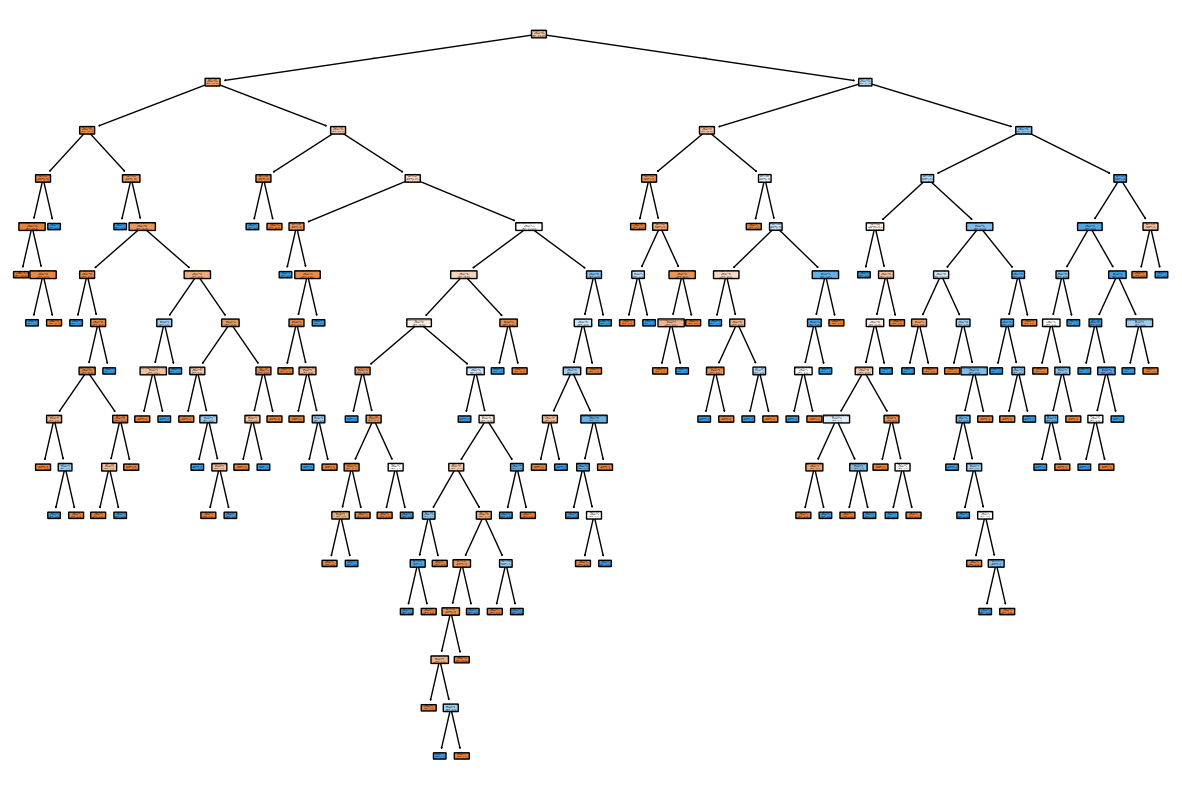

In [6]:
plt.figure(figsize=(15, 10))
tree.plot_tree(dt_classifier,
               feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],  # Ajuste según las etiquetas
               filled=True,
               rounded=True)
plt.savefig('arbol_decision_diabetes.png')
plt.show()

## 4. Afinamiento de hiperparámetros

Para las siguientes técnicas afine los hiperparámetros del modelo usando los siguientes parámetros de la clase `DecisionTreeClassifier`:


*   max_depth: None, 5, 10, 15, 20
*   min_samples_split: 2, 5, 10
*   min_samples_leaf: 1, 2, 4

### 4.1 *Latin Hypercube Sampling* (LHS)

Utilizando el script en [Latin Hypercube Sampling (LHS) - Integrated Computational Materials Engineering (ICME)](https://www.cavs.msstate.edu/icme/DesignOpt/LHS.php) genere un muestreo en el espacio de búsqueda de los hiperparámetros antes mencionados. Genere entre 35 y 40 muestras. Luego utilice dichas muestras para crear un experimento que permita afinar los hiperparámetros.

In [11]:
param_ranges = {
    'max_depth': (5, 20),
    'min_samples_split': (2,10),
    'min_samples_leaf': (1, 4),
    'max_features': (0.1, 1.0)  # Make sure this is a tuple with 2 values
}

# Número de muestras
n_samples = 40
n_params = len(param_ranges)

# Latin Hypercube Sampling
lhs_sample = lhs(n_params, samples=n_samples)

# Escalar las muestras al rango de cada parámetro
param_names = list(param_ranges.keys())
param_samples = []

for i, param in enumerate(param_names):
    # Use try-except to handle potential errors when unpacking
    try:
        low, high = param_ranges[param]
        scaled = lhs_sample[:, i] * (high - low) + low
        if param != 'max_features':
            scaled = np.round(scaled).astype(int)
        param_samples.append(scaled)
    except ValueError as e:
        print(f"Error processing parameter '{param}': {e}")
        print(f"Value in param_ranges: {param_ranges[param]}")
        raise


param_df = pd.DataFrame(np.array(param_samples).T, columns=param_names)
y_target = df_diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.15, random_state=42)

results = []

for i, row in param_df.iterrows():
    # Handle potential issues with max_features
    max_features_value = row['max_features']
    # Ensure max_features is valid (between 0 and 1 or "auto", "sqrt", "log2")
    if isinstance(max_features_value, (int, float)) and (max_features_value <= 0 or max_features_value > 1):
        max_features_value = min(max(max_features_value, 0.1), 1.0)
    
    clf = DecisionTreeClassifier(
        max_depth=int(row['max_depth']),
        min_samples_split=int(row['min_samples_split']),
        min_samples_leaf=int(row['min_samples_leaf']),
        max_features=max_features_value,
        random_state=42
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((i, acc))

# Agregar resultados al DataFrame
param_df['accuracy'] = [acc for _, acc in results]

# Show top 5 parameter combinations
print("Top 5 parameter combinations:")
print(param_df.sort_values('accuracy', ascending=False).head(5))

Top 5 parameter combinations:
    max_depth  min_samples_split  min_samples_leaf  max_features  accuracy
14        6.0                7.0               3.0      0.989828  0.793103
5         6.0                4.0               2.0      0.948083  0.784483
25        7.0                8.0               3.0      0.390558  0.767241
35        8.0                8.0               1.0      0.896049  0.758621
29       12.0                9.0               2.0      0.786503  0.750000


#### 4.1.1 Métricas

Obtenga la exactitud, la matriz de confusión y el informe de clasificación.

In [12]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud (Accuracy): {accuracy:.3f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Informe de Clasificación:")
print(class_report)

Exactitud (Accuracy): 0.629
Matriz de Confusión:
[[56 20]
 [23 17]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        76
           1       0.46      0.42      0.44        40

    accuracy                           0.63       116
   macro avg       0.58      0.58      0.58       116
weighted avg       0.62      0.63      0.63       116



#### 4.1.2 Visualización del árbol

Visualice el árbol.

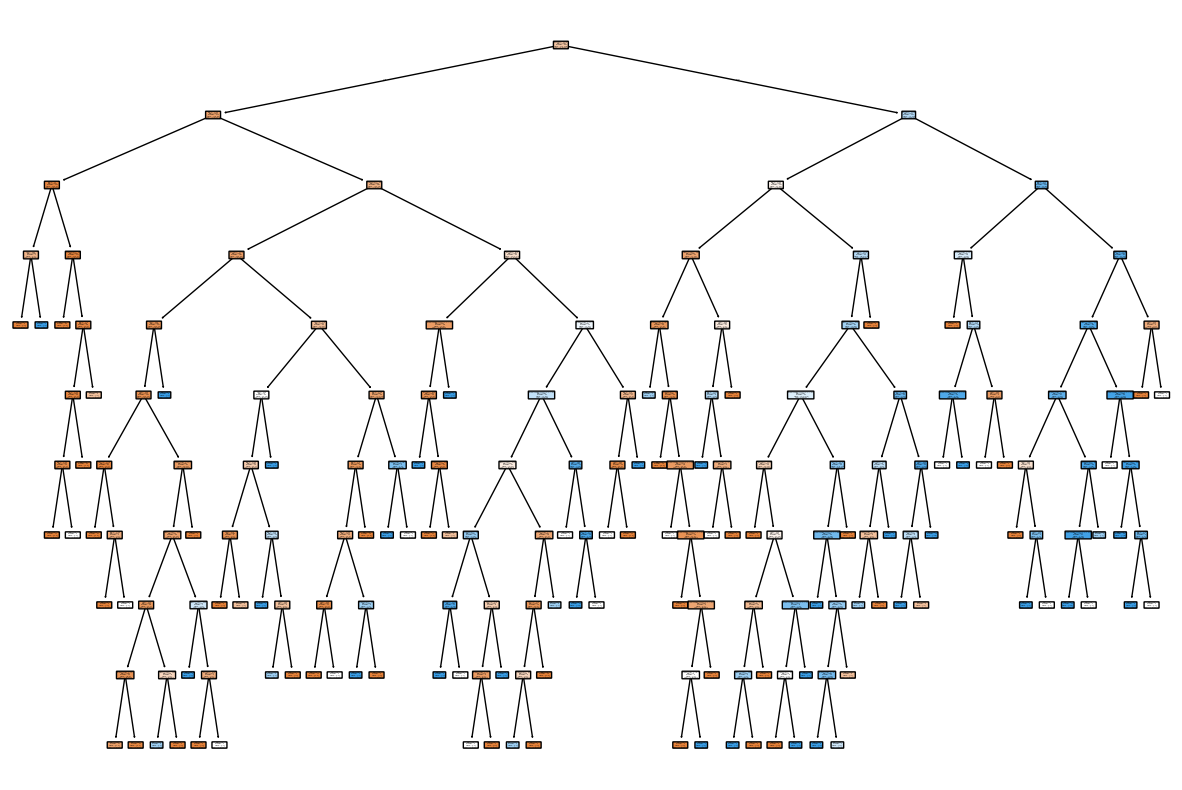

In [13]:
plt.figure(figsize=(15, 10))
tree.plot_tree(clf,
               feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],  # Adjust according to the labels
               filled=True,
               rounded=True)
plt.savefig('arbol_decision_diabetes_lhs.png')
plt.show()

### 4.2 Optuna

Utilizando el marco de trabajo [Optuna](https://optuna.org/) genere ensayos en el espacio de búsqueda de los hiperparámetros antes mencionados. Genere 30 a 45 ensayos. Con esas especificaciones genere un experimento que permita afinar los hiperparámetros.

#### 4.2.1 Métricas

Obtenga la exactitud, la matriz de confusión y el informe de clasificación.

In [16]:
import optuna
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_float('max_features', 0.1, 1.0) # suggest_uniform is deprecated

    # Create the Decision Tree Classifier with suggested hyperparameters
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Perform cross-validation and return the mean accuracy
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Print the best hyperparameters and accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Train the final model with the best hyperparameters
best_params = study.best_params
clf = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud (Accuracy): {accuracy:.3f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Informe de Clasificación:")
print(class_report)

[I 2025-05-10 16:29:49,284] A new study created in memory with name: no-name-5855f214-5cdf-4079-8651-774a25612113
[I 2025-05-10 16:29:49,312] Trial 0 finished with value: 0.7071051086318262 and parameters: {'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.28743342875058286}. Best is trial 0 with value: 0.7071051086318262.
[I 2025-05-10 16:29:49,344] Trial 1 finished with value: 0.7208103347034646 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.9622547989051472}. Best is trial 1 with value: 0.7208103347034646.
[I 2025-05-10 16:29:49,374] Trial 2 finished with value: 0.7039459776864356 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.6802074055150062}. Best is trial 1 with value: 0.7208103347034646.
[I 2025-05-10 16:29:49,403] Trial 3 finished with value: 0.7300528479154433 and parameters: {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2, 'm

Best hyperparameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.7201651415284207}
Best accuracy: 0.7453200234879624
Exactitud (Accuracy): 0.767
Matriz de Confusión:
[[60 16]
 [11 29]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        76
           1       0.64      0.72      0.68        40

    accuracy                           0.77       116
   macro avg       0.74      0.76      0.75       116
weighted avg       0.78      0.77      0.77       116



#### 4.2.2 Visualización del árbol

Visualice el árbol.

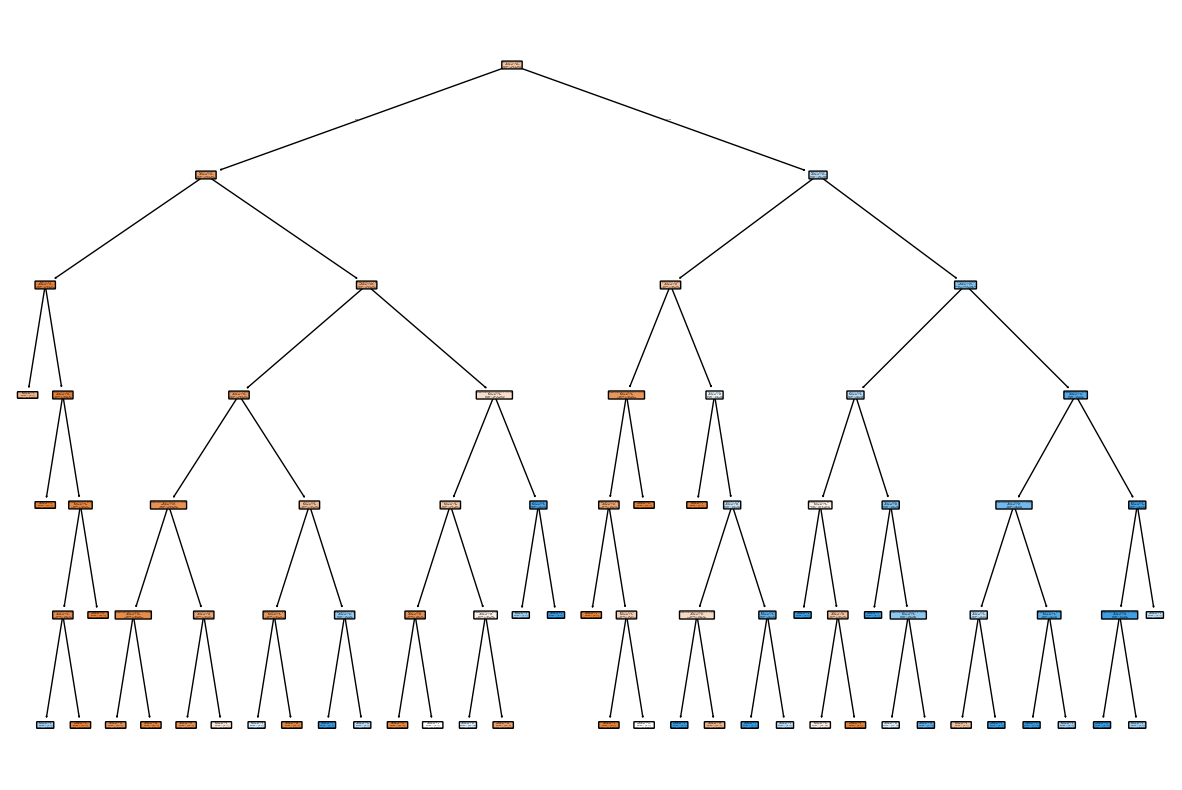

In [17]:
plt.figure(figsize=(15, 10))
tree.plot_tree(clf,
               feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],  # Adjust according to the labels
               filled=True,
               rounded=True)
plt.savefig('arbol_decision_diabetes_optuna.png')
plt.show()

### 4.3 GridSearchCV de Scikit-Learn

Utilizando la clase GridSearchCV de Scikit-Learn genere una búsqueda en el espacio de antes mencionados.

#### 4.3.1 Métricas

Obtenga la exactitud, la matriz de confusión y el informe de clasificación.

In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 0.1, 0.5, 0.75, 1.0]
}

# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Train the final model with the best parameters
clf = DecisionTreeClassifier(**best_params, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.3f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best Parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation Accuracy: 0.7606694069289489
Test Accuracy: 0.802
Confusion Matrix:
[[65 11]
 [12 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        76
           1       0.72      0.70      0.71        40

    accuracy                           0.80       116
   macro avg       0.78      0.78      0.78       116
weighted avg       0.80      0.80      0.80       116



#### Confusion matrix and graph of the parameters

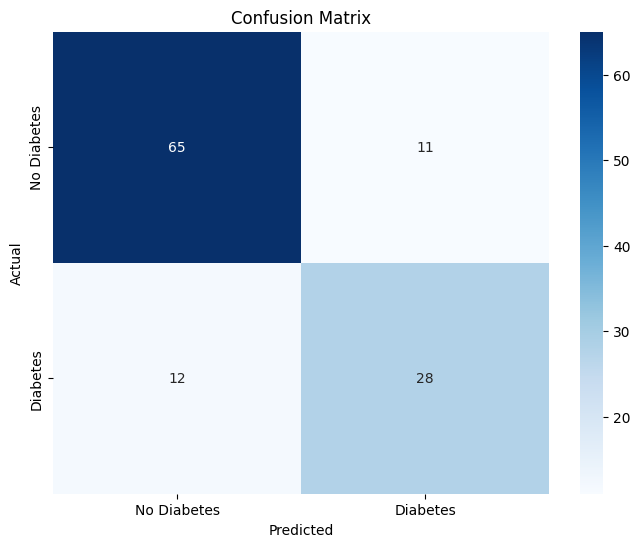

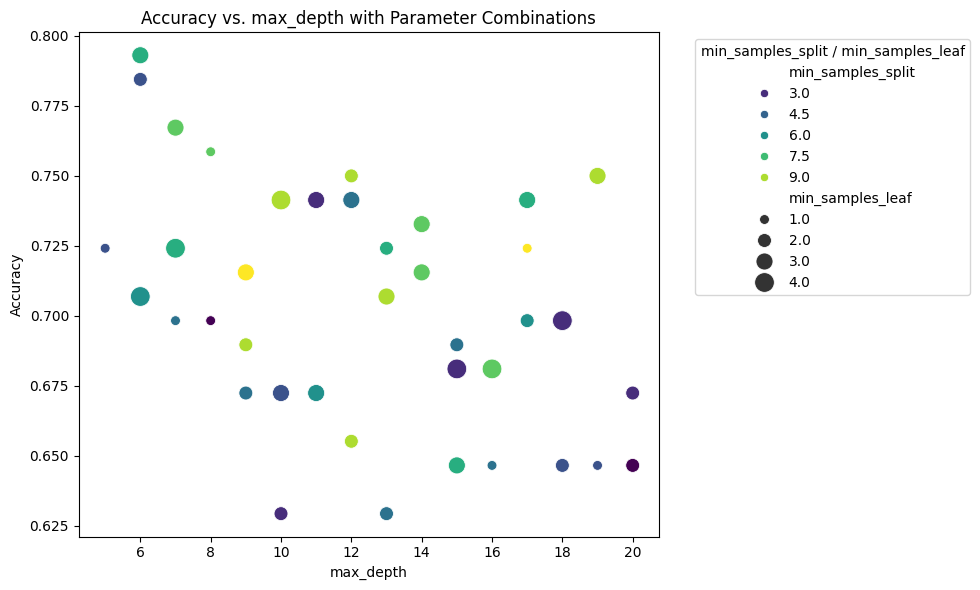

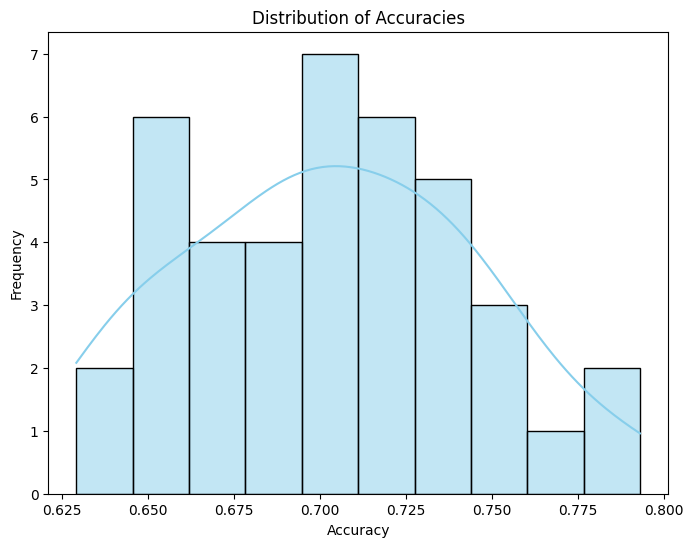

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot the accuracy of the parameter combinations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=param_df, x='max_depth', y='accuracy', hue='min_samples_split', size='min_samples_leaf', sizes=(50, 200), palette='viridis')
plt.title('Accuracy vs. max_depth with Parameter Combinations')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend(title='min_samples_split / min_samples_leaf', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot the distribution of accuracies
plt.figure(figsize=(8, 6))
sns.histplot(param_df['accuracy'], kde=True, bins=10, color='skyblue')
plt.title('Distribution of Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

#### 4.3.2 Visualización del árbol

Visualice el árbol.

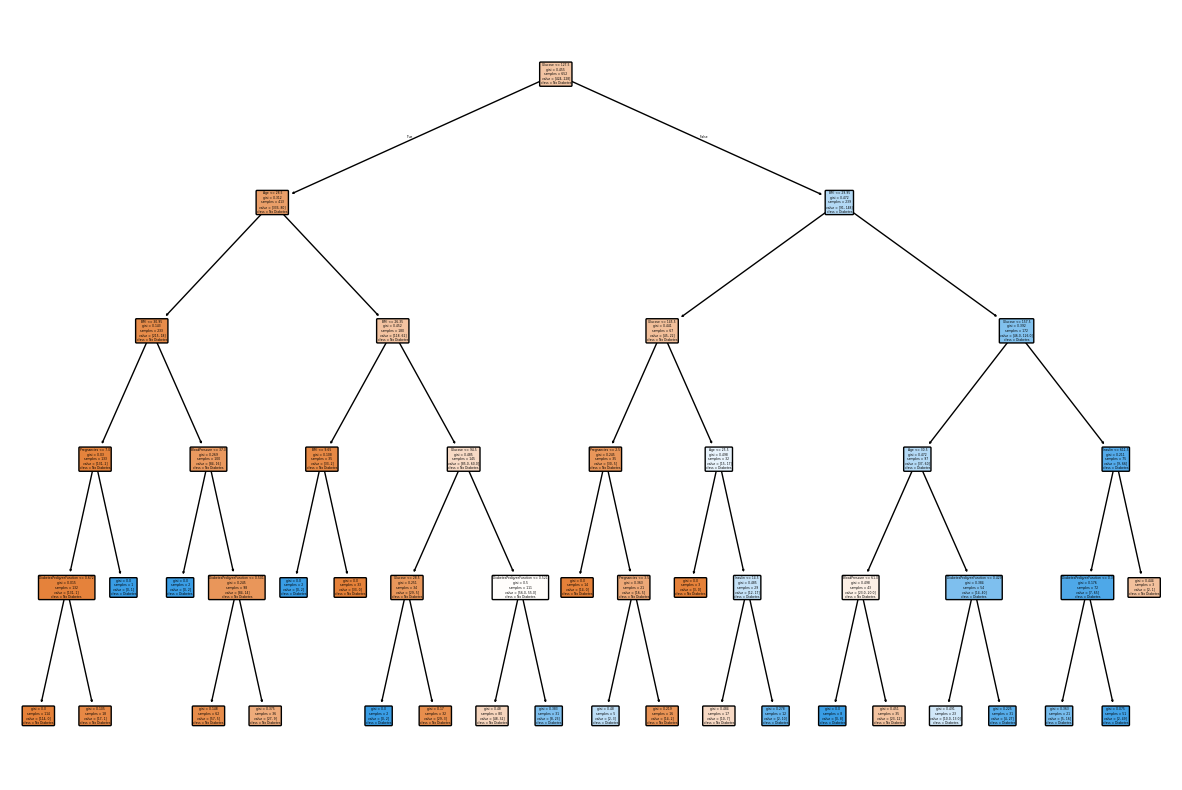

In [20]:
plt.figure(figsize=(15, 10))
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=['No Diabetes', 'Diabetes'],  # Adjust according to the labels
               filled=True,
               rounded=True)
plt.savefig('arbol_decision_diabetes_gridsearchcv.png')
plt.show()

## 5 Comparación de los modelos

Cree una tabla de métricas del mejor modelo de las técnicas de regresión lineal y de árbol de decisión. Compare, analice y haga una interpretación del resultado..